# Anchored advected interfaces, Oslo model, and roughness at depinning
## Assaf Shapira and Kay Jörg Wiese
(tested in  Julia 1.6 and 1.8.5)

In [1]:
# libraries and general settings
ENV["GKS_ENCODING"]="utf8"
using Random
using Distributions
using ProgressMeter
using Plots
using LaTeXStrings
using DataFrames
using GLM

default(label=false)

function linreg(X,Y)
    df = DataFrame(Y=Y,X=X)
    fm = @formula(Y ~ 1 + X)
    reg = coef(lm(fm, df))
    return reg[2],reg[1] #slope, intercept
end;

In [2]:
# A configuration is a vector of 0 and 1. The height function is the cumulative sum: 
# h = cumsum(c) - ρL

# initial configuration
function random_c(L::Int, ρ)
    z = round(Int,L * ρ)
    c = [ones(Int,z)..., zeros(Int,L-z)...]
    shuffle!(c)
    return c
end

# SEP step: exchange two neighboring sites (transitions 1 and 2 of section 2.1).
# The left boundary is Dirichlet.
# The right boundary is open, i.e., we assume a random occupation at site L+1
function sep_step(c::Vector{Int}, ρ)
    L = length(c)
    i = rand(1:L)
    if i==L
        c[L]= Int(rand()<ρ)
    else
        tmp = c[i]
        c[i] = c[i+1]
        c[i+1] = tmp
    end
end

# Directed step (transitions 3 and 4 of section 2.1):
# 110 becomes 011 with rate 1
# 001 becomes 100 with rate r<1
# Left boundary is Dirichlet, right boundary is open, i.e. 
# random occupations at sites L+1 and L+2
function d_step(c::Vector{Int}, ρ, r)
    L = length(c)
    i = rand(1:L)
    if i < L-1
        if c[i] == 1 && c[i+1] == 1 && c[i+2] == 0
            c[i] = 0
            c[i+2] = 1
        elseif c[i] == 0 && c[i+1] == 0 && c[i+2] == 1
            if rand() < r
                c[i] = 1
                c[i+2] = 0
            end
        end
    elseif i == L-1
        if c[i] == 1 && c[i+1] == 1
            c[i] == Int(rand()<ρ)
        elseif c[i] == 0 && c[i+1] == 0
            c[i] == Int(rand()<ρ*r)
        end
    else #i==L
        if c[i] == 1
            c[i] = Int(rand()>ρ*(1-ρ))
        else
            c[i] = Int(rand()<r*(1-ρ)*ρ)
        end
    end
end

# the full update used in the simulation
function DEP_step(c::Vector{Int}, ρ, r)
    if rand()>(1+r)/(3+r)
        d_step(c, ρ, r)
    else
        sep_step(c, ρ)
    end
end;

# Main routine to estimate the roughness

Progress: 100%|█████████████████████████████████████████| Time: 1 days, 0:00:57m


empirical densiy = 0.5000282907149085


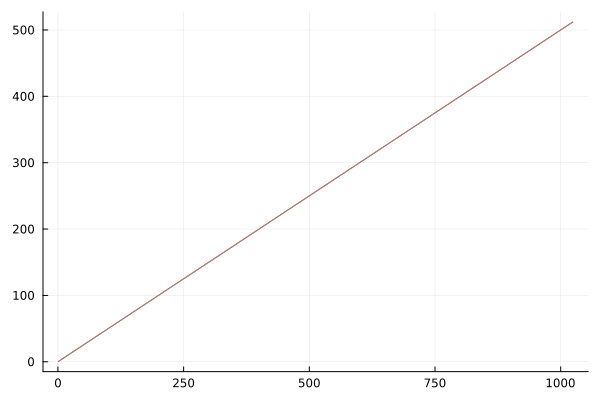

In [3]:
# model parameters: rate r and system size L
r = 1
ρ = r/(1+r)  # we simulate the critical density
L = 2^10      
N = 10*L^3   # number of single-site updates
# the simultion time is N/L/(3+r)

# initialization 
c = random_c(L,ρ)
# relax the system before measurement
for i in 1:4*L^2
    DEP_step(c, ρ, r)
end

#initialize empty vectors
h_avg = zeros(L)
h2_avg = zeros(L)
h = zeros(L)

@showprogress for i in 1:N
    DEP_step(c, ρ, r)
    h = cumsum(c) # the cumulative sum
    h_avg .+= h
    h2_avg .+= h .^2
end

h_avg ./= N
h2_avg ./= N
h_var = h2_avg .- h_avg.^2

println("empirical densiy = ",h_avg[L]/L)

plot(h_avg)
plot!(ρ*(1:L))

L"$\langle h(x)^2 \rangle ^2 = 0.14 x + -2.047$"

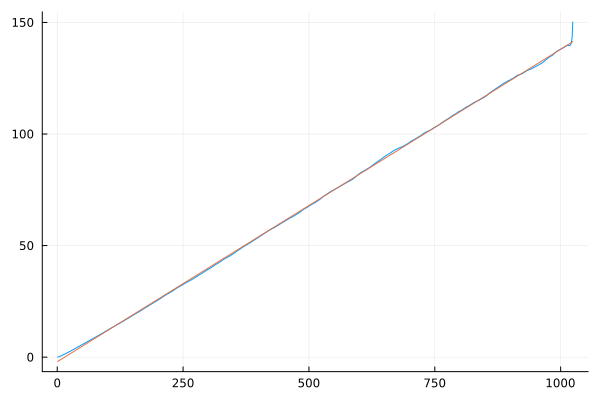

In [4]:
### symmetric case (r = 1)
slope,intercept = linreg(1:L,h_var .^2)
display(L"\langle h(x)^2 \rangle ^2 = %$(round(slope,digits=3)) x + %$(round(intercept,digits=3))")
plot(h_var .^2)
plot!(1:L, slope*(1:L) .+ intercept)

### asymmetric case (r ≠ 1)
# slope,intercept = linreg(1:L,h_var .^1.5)
# println("<h(x)^2>^1.5 = ", slope ," x + ",intercept)
# plot(h_var .^1.5)
# plot!(1:L, slope*(1:L) .+ intercept)

# Dynamic exponent
We measure temporal correlations, and collapse the graphs according to 
$$
\left < h(x,t) h(x,0) \right > = x^{2\zeta} f(t x^{-z}) 
$$

In [5]:
# data structure to keep the last history_size configurations
mutable struct MovingConfiguration
    _data::Array{Float64, 2}
    history_size::Int
    current_shift::Int
    
    # initialization
    function MovingConfiguration(history_size::Int,L::Int)
        new(zeros(history_size, L),history_size,0)
    end
end

# access data
function Base.getindex(m::MovingConfiguration, idx::Int64) 
    i = (idx+m.current_shift-1)%m.history_size + 1
    view(m._data,i,:)
end

function TimeShift(m::MovingConfiguration)
    m.current_shift += 1
end;

In [6]:
# model parameters: rate r and system size L
r = 1
ρ = r/(1+r) # critical density

lgL = 13
L = 2^lgL # the system size
x_list = [2 ^ i for i in 0:lgL] # only save configurations at these positions
N = 2000 # iterations

# intialize configuration c
c = random_c(L,ρ) 
# initial relaxation
for i in 1:4*L^2
    DEP_step(c, ρ, r)
end


measurement_time = L÷3
Δt = 4  # smaller Δt takes longer but produces smoother graph

# intialize all arrays to 0
# past_h[i] is the configuration at time t - measurement_time + (i-1)Δt
past_h = MovingConfiguration(measurement_time ÷ Δt,lgL+1) 
#corr[k,i] will contain <h(2^(k-1),t)h(2^(k-1),t+(i-1)Δt)>
corr = zeros(lgL+1,measurement_time ÷ Δt + 1)  
h_avg = zeros(lgL+1)
corr0 = zeros(lgL+1)

for i in 1:(measurement_time ÷ Δt)
    past_h[i] .= cumsum(c)[x_list]
    for k in Δt*L*(r+3)  #Δt time units corresponds to LΔt*(r+3) Markov steps
        DEP_step(c, ρ, r)
    end
end

@showprogress for j in 1:(N*measurement_time)
    h = cumsum(c)[x_list]
    
    h_avg .+=  h
    corr[:,1] .+= h .* h
    for i in 2:(measurement_time ÷ Δt)
        corr[:,i] .+= h .* past_h[measurement_time ÷ Δt - i + 1]
    end
    
    TimeShift(past_h)
    past_h[measurement_time ÷ Δt] .= h
    
    for k in 1:Δt*L*(r+3)
        DEP_step(c, ρ, r)
    end
end

h_avg ./= (N*measurement_time);
corr ./= (N*measurement_time);
for i in 1:(measurement_time ÷ Δt + 1)
    corr[:,i] .-= h_avg.^2;
end

Progress: 100%|█████████████████████████████████████████| Time: 1 days, 5:24:29m


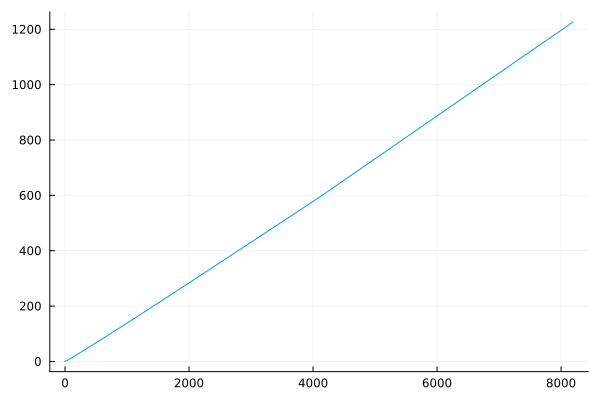

In [14]:
#recheck roughness
ζ = 0.25
plot(x_list,max.(0,corr[:,1]).^(1/ζ/2)) 

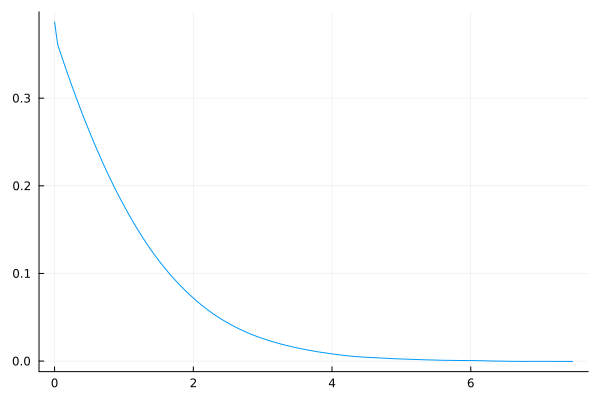

In [31]:
z = 0.5   

# plot the correlations for x=L
lgx=lgL
x=2^lgx

last_time =  round(Int,0.25*( measurement_time ÷ Δt * (x/L)^z))

t_renormalized = (0:Δt:measurement_time) ./ x^z
fig = plot(t_renormalized[1:last_time], (x^(-2*ζ) .* corr[lgx+1,1:last_time]))

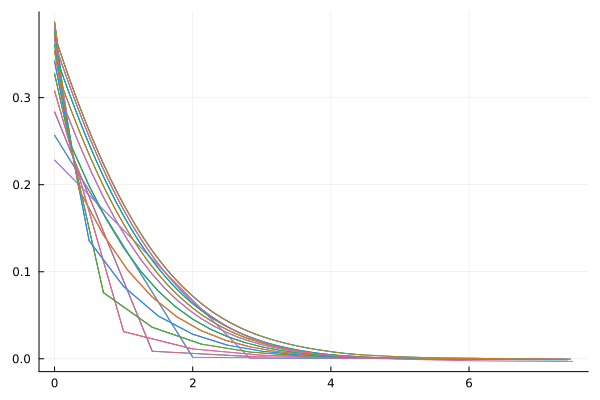

In [34]:
for lgx in 1:lgL
    x=2^lgx
    last_time = round(Int,0.25*(measurement_time ÷ Δt * (x/L)^z))
    t_renormalized = (0:Δt:measurement_time) ./ x^z
    plot!(fig,t_renormalized[1:last_time], (x^(-2*ζ) .* corr[lgx+1,1:last_time]))
end
display(fig)